<a href="https://colab.research.google.com/github/sgulyano/mat202/blob/main/lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MAT-202 Lab 2: ARIMA Forecasting

CMKL University

By Sarun Gulyanon


### Goal

learn how to apply ARIMA (Autoregressive Integrated Moving Average) models for time series forecasting.

### Outline

In this lab, we will:
1. Explore a real-world time series dataset  
2. Test for stationarity (ADF test) and apply differencing  
3. Analyze ACF and PACF plots to select ARIMA parameters  
4. Build and fit ARIMA models using Python (`statsmodels`)  
5. Forecast future values and compare against actual data  
6. Evaluate model accuracy and interpret results

----

# 1. Data Collection

For this lab, we will use the [Air Passengers](https://www.kaggle.com/datasets/rakannimer/air-passengers) dataset from Kaggle.  
This dataset records the monthly total number of international airline passengers.


In [1]:
# #!/bin/bash
!curl -L -o ./air-passengers.zip\
  https://www.kaggle.com/api/v1/datasets/download/rakannimer/air-passengers
!unzip air-passengers.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   764  100   764    0     0   1260      0 --:--:-- --:--:-- --:--:--  3380
Archive:  air-passengers.zip
replace AirPassengers.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: AirPassengers.csv       


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_csv("AirPassengers.csv", parse_dates=['Month'], index_col='Month')

In [4]:
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   #Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


# 2. Data Preprocessing

An ARIMA model requires the input time series to be *stationary* (constant mean and variance over time). To verify this, we will apply the *Augmented Dickey–Fuller (ADF) test* to check for stationarity. We will see that applying *differencing* help transform the data into a stationary form.

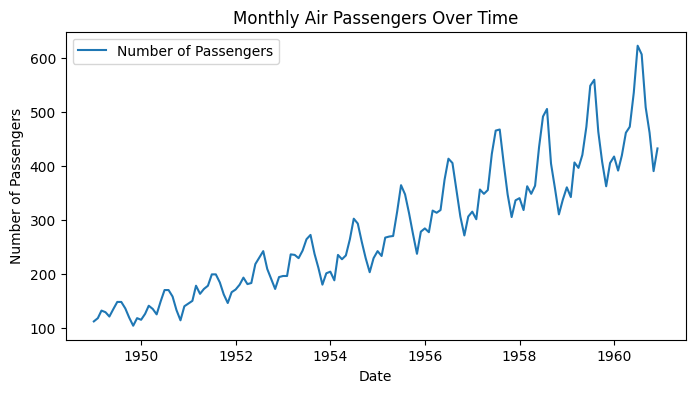

In [6]:
# Plotting the original time series
plt.figure(figsize=(8, 4))
plt.plot(df.index, df["#Passengers"], label='Number of Passengers')
plt.title('Monthly Air Passengers Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

In [7]:
result_original = adfuller(df['#Passengers'])
print(f"ADF Statistic (Original): {result_original[0]:.4f}")
print(f"p-value (Original): {result_original[1]:.4f}")

if result_original[1] < 0.05:
    print("Interpretation: The original series is likely Stationary.\n")
else:
    print("Interpretation: The original series is Non-Stationary.\n")

df['Passengers_Diff'] = df['#Passengers'].diff()

# ADF test on differenced series
result_diff = adfuller(df['Passengers_Diff'].dropna())
print(f"ADF Statistic (1st Difference): {result_diff[0]:.4f}")
print(f"p-value (1st Difference): {result_diff[1]:.4f}")

if result_diff[1] < 0.05:
    print("Interpretation: The differenced series is Stationary.")
else:
    print("Interpretation: The differenced series is still Non-Stationary.")


ADF Statistic (Original): 0.8154
p-value (Original): 0.9919
Interpretation: The original series is Non-Stationary.

ADF Statistic (1st Difference): -2.8293
p-value (1st Difference): 0.0542
Interpretation: The differenced series is still Non-Stationary.


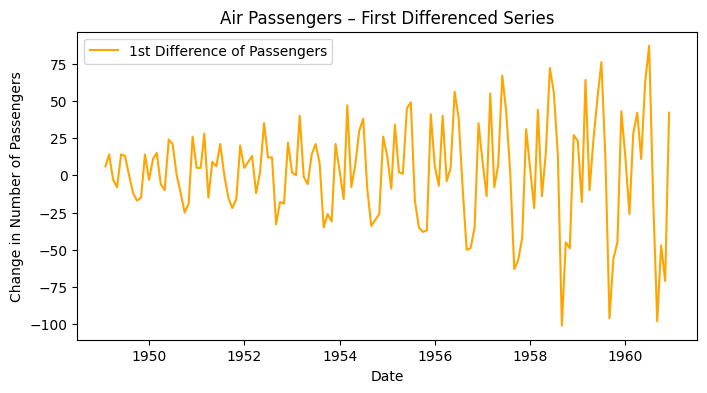

In [8]:
# Plotting the differenced passenger series
plt.figure(figsize=(8, 4))
plt.plot(df.index, df['Passengers_Diff'], label='1st Difference of Passengers', color='orange')
plt.title('Air Passengers – First Differenced Series')
plt.xlabel('Date')
plt.ylabel('Change in Number of Passengers')
plt.legend()
plt.show()

Once the series is stationary, the next step is to identify suitable ARIMA parameters.

We use two tools for this:

- **Autocorrelation Function (ACF):** Helps identify the order of the Moving Average (MA, q) component.  
- **Partial Autocorrelation Function (PACF):** Helps identify the order of the Autoregressive (AR, p) component.  

By examining the ACF and PACF plots of the differenced series, we can propose initial values of `(p, d, q)` to use in the ARIMA model.

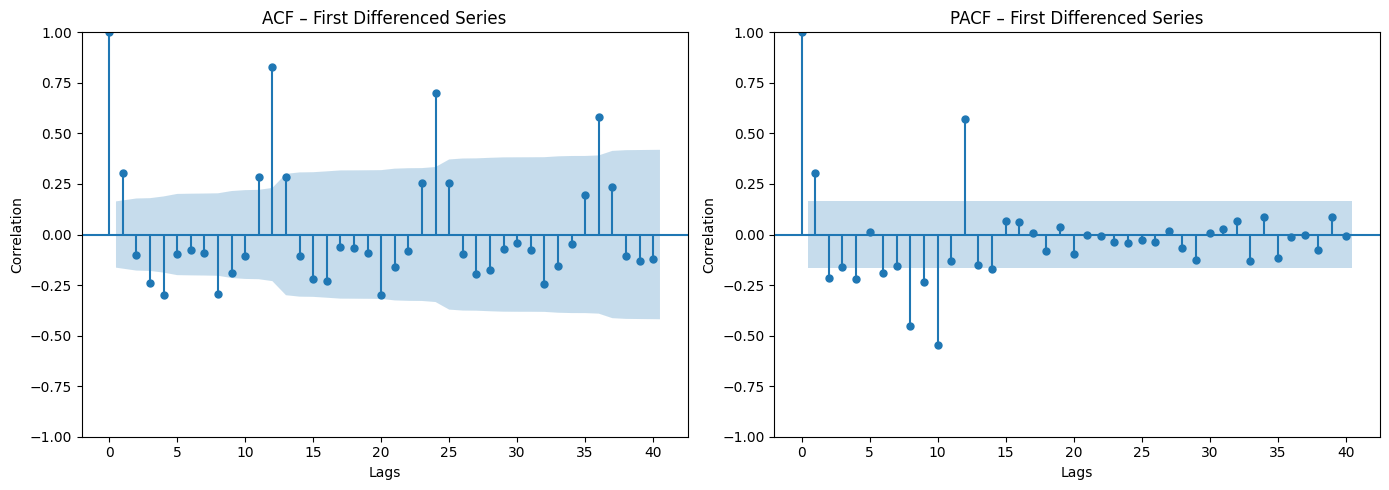

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot ACF and PACF for the first-differenced series
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Autocorrelation Function (ACF)
plot_acf(df['Passengers_Diff'].dropna(), lags=40, ax=axes[0])
axes[0].set_title('ACF – First Differenced Series')
axes[0].set_xlabel('Lags')
axes[0].set_ylabel('Correlation')

# Partial Autocorrelation Function (PACF)
plot_pacf(df['Passengers_Diff'].dropna(), lags=40, ax=axes[1], method='ywm')
axes[1].set_title('PACF – First Differenced Series')
axes[1].set_xlabel('Lags')
axes[1].set_ylabel('Correlation')

plt.tight_layout()
plt.show()


# 3. Forecasting

In this step, we will:
1. Split the dataset into **training** and **testing** sets.  
2. Fit the ARIMA model on the training data.  
3. Forecast the values for the testing period.  
4. Plot the predicted values against the actual data.  
5. Evaluate forecast performance.

In [10]:
# Train/test split
train_size = int(len(df['#Passengers']) * 0.8)   # 80% train, 20% test
train, test = df['#Passengers'].iloc[:train_size], df['#Passengers'].iloc[train_size:]


In [11]:
# Fit ARIMA on training
model = ARIMA(train, order=(2,1,2))
model_fit = model.fit()

print(model_fit.summary())

# Rolling Forecast (Walk-forward)
history = list(train)
preds = []

for t in range(len(test)):
    model = ARIMA(history, order=(2,1,2))
    fit = model.fit()
    yhat = fit.forecast()[0]
    preds.append(yhat)
    history.append(test.iloc[t])   # update with actual value

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  115
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -523.758
Date:                Mon, 29 Sep 2025   AIC                           1057.516
Time:                        04:04:54   BIC                           1071.197
Sample:                    01-01-1949   HQIC                          1063.069
                         - 07-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3280      0.145      2.268      0.023       0.045       0.611
ar.L2          0.2521      0.165      1.528      0.126      -0.071       0.575
ma.L1         -0.0125      0.109     -0.114      0.9

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

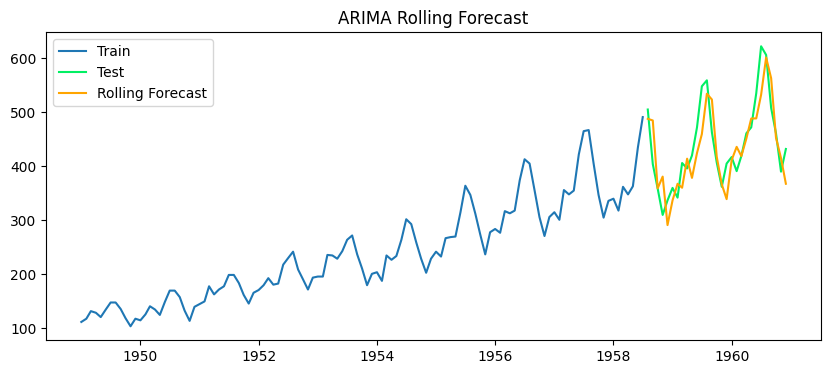

Rolling Forecast RMSE: 44.95461423133032


In [12]:
plt.figure(figsize=(10,4))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test", color='#01ef63')
plt.plot(test.index, preds, label="Rolling Forecast", color="orange")
plt.title("ARIMA Rolling Forecast")
plt.legend(); plt.show()

# Error
mse = mean_squared_error(test, preds)
print("Rolling Forecast RMSE:", np.sqrt(mse))

In [13]:
print(f"AIC: {fit.aic}")
print(f"BIC: {fit.bic}")

AIC: 1339.0863845068034
BIC: 1353.8655197948096


---